# Topic Modeling with Pandas

In [1]:
import pandas as pd

movie = pd.read_csv('movie_data_new.csv', header = None) # header를 None으로 설정해 header가 없음을 알림

print('리뷰 수:', len(movie))
print('리뷰영화:', set(movie.iloc[:,2])) # ix가 사라져 iloc으로 대체

리뷰 수: 14967
리뷰영화: {'인피니티 워', '라라랜드', '범죄도시', '신과함께', '택시운전사', '곤지암', '코코'}


In [2]:
movie[:10]

,0,1,2
0,헐..다 죽었어....나중에 앤트맨 보다가도 깜놀...,10,인피니티 워
1,충격 결말,9,인피니티 워
2,응집력,8,인피니티 워
3,개연성은 무시해라 액션을 즐겨라 스타로드가 이끌어준다 각각의 영웅들을 즐겨라 그리고...,8,인피니티 워
4,내가졸라이상하네,4,인피니티 워
5,대박,10,인피니티 워
6,정말 지루할틈없이 넘잘만들었다 역시 대단하다,9,인피니티 워
7,역시 어벤져스!!,9,인피니티 워
8,마지막에 누구한테 연락한거지? 궁금,9,인피니티 워
9,다음 편이 궁굼해지네요^^,10,인피니티 워


In [3]:
text = movie.iloc[:,0] # 전체행에 대해 1번째 열만 인덱싱 - 리뷰들만 가져옴

#### topic modeling은 count vector를 사용하므로 sklearn의 CountVectorizer를 사용

In [4]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=twitter_tag.nouns, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(text)

In [5]:
review_cv.shape

(14967, 1000)

#### sklearn의 LatentDirichletAllocation을 이용하여 topic modeling 수행

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [7]:
print('topic-word distribution dimension:', lda.components_.shape)
print('document-topic distribution dimenstion', review_topics.shape)

topic-word distribution dimension: (10, 1000)
document-topic distribution dimenstion (14967, 10)


#### topic을 보기 쉽게 출력하는 함수를 작성

In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

In [9]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 정말, 생각, 기대, 원작, 내, 안, 인생, 작품, 난, 굿
Topic #1: 더, 그, 광주, 말, 다시, 가슴, 우리, 한번, 송강호, 택시
Topic #2: 것, 좀, 장면, 때, 나, 음악, 사랑, 이야기, 번, 현실
Topic #3: 스토리, 시간, 돈, 정도, 신파, 감독, 거, 한국, 듯, 수준
Topic #4: 그냥, 편, 마블, 뭐, 이해, 공포, 역시, 노스, 느낌, 다음
Topic #5: 마동석, 최고, 볼, 함, 액션, 공포영화, 임, 완전, 걸, 중
Topic #6: 사람, 점, 수, 꼭, 부분, 이, 분, 웹툰, 조금, 인간
Topic #7: 감동, 눈물, 재미, 마지막, 보고, 내용, 가족, 처음, 끝, 추천
Topic #8: 연기, 배우, 진짜, 왜, 윤계상, 차태현, 연출, 또, 대박, 모두
Topic #9: 영화, 이, 평점, 만, 관객, 신, 천만, 비, 알바, 제



#### 한 자로 구성된 명사들 삭제 

In [10]:
twitter_tag.nouns(text[1])

['충격', '결말']

In [11]:
def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [12]:
tokenizer(text[1])

['충격', '결말']

#### count vector 생성

In [13]:
#count vector 새로 생성
vec = CountVectorizer(tokenizer=tokenizer, decode_error ='ignore', 
                      max_df=0.5, max_features = 1000) #너무 자주 나타나는 단어는 제외
review_cv = vec.fit_transform(text)

In [14]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 50, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 지금, 나름, 영화, 모든, 시간, 조폭, 아픔, 재판, 고생, 스토리
Topic #1: 가족, 조연, 주연, 영화, 공감, 디즈니, 점수, 픽사, 감동, 스트레스
Topic #2: 영화, 어른, 얼마나, 충격, 더욱, 여기, 폭력, 사람, 설명, 감동
Topic #3: 진짜, 소리, 인간, 엄마, 동생, 줄거리, 아무, 상상력, 장첸, 기담
Topic #4: 한번, 영화, 사실, 표현, 개봉, 절대, 곤지암, 외국, 해도, 묘사
Topic #5: 신파, 몰입, 명작, 기술, 박수, 얼굴, 아주, 영화, 표정, 내년
Topic #6: 생각, 대박, 수준, 극장, 영화, 스토리, 가지, 유머, 걱정, 사람
Topic #7: 기억, 억지, 반전, 얘기, 감동, 개연, 형사, 장면, 영화, 슬픔
Topic #8: 한국, 차태현, 위해, 제대로, 발전, 모습, 신파극, 영화, 인정, 효과
Topic #9: 추천, 다음, 강추, 범죄, 도시, 꿀잼, 영화, 전반, 오역, 만큼
Topic #10: 부분, 지옥, 영화, 대해, 장면, 자극, 감동, 사람, 스릴, 마지막
Topic #11: 평점, 영화, 아쉬움, 이유, 혼자, 스크린, 흐름, 추격, 수가, 깡패
Topic #12: 원작, 대한, 전혀, 아들, 대사, 오히려, 내용, 배경, 문제, 수작
Topic #13: 한국영, 정말, 영화, 영화로, 제발, 마무리, 그냥, 상상, 이영화, 사건
Topic #14: 광주, 역사, 시민, 가슴, 전두환, 기자, 민주주의, 그날, 사복, 독일
Topic #15: 정말, 모두, 관객, 감독, 영화, 시대, 희생, 나라, 반복, 고민
Topic #16: 사랑, 영화, 이제, 가장, 집중, 감성, 갈수록, 겨울왕국, 최근, 소름
Topic #17: 웹툰, 조금, 영화, 설정, 생각, 상황, 누구, 현실, 스토리, 그대로
Topic #18: 영화, 이상, 보지, 이후, 오락, 감사, 선택, 헐리웃, 장난, 불가
Topic #19: 송강호, 택시, 천만, 운전사, 배우

####  topic들을 대상으로 clustering을 수행해서 topic들이 잘 묶을 수 있는지 확인

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5) #5개 클러스터로 분류
kmeans.fit(lda.components_)

print('topic-word distribution dimension:', lda.components_.shape)
print('Cluster label:', kmeans.labels_)

topic-word distribution dimension: (50, 1000)
Cluster label: [4 4 4 1 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4
 4 4 4 4 4 4 0 4 4 4 4 4 4]


#### T-SNE를 이용하여 각 topic들 간의 관계를 시각화

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_review = tsne.fit_transform(lda.components_)
print('TSNE dimension:', tsne_review.shape)
tsne_review[:,0]

TSNE dimension: (50, 2)


array([  -2.497567  ,  -97.41527   ,  -96.72706   ,  112.653595  ,
         -0.27839005,  -92.06018   ,  -73.94048   ,   20.240171  ,
          5.570263  ,   62.6582    ,    6.705569  ,   33.317593  ,
        105.56773   ,  -15.259136  , -139.19035   ,   77.81543   ,
         35.65345   ,   22.675673  ,   -2.4460883 ,   99.97188   ,
        -46.232323  , -115.36131   ,  -46.10928   ,   26.325891  ,
        -52.459026  ,   -9.034661  ,  -20.139458  ,   16.668293  ,
         27.599745  ,  -77.10113   ,   15.1262665 ,   66.870255  ,
        -23.464151  ,  -26.334356  ,  -15.747093  ,  -60.961254  ,
        -32.191948  ,  -79.184685  ,  -36.309803  ,   45.059055  ,
        -37.136917  ,   37.079433  ,  -18.446463  ,  -21.458206  ,
         71.32376   ,    6.51886   ,   46.76818   ,  -43.744556  ,
        -63.96116   ,   64.44952   ], dtype=float32)

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

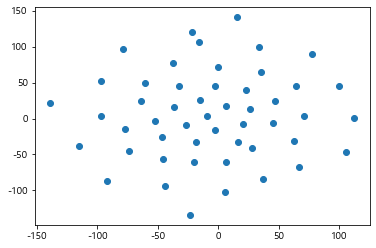

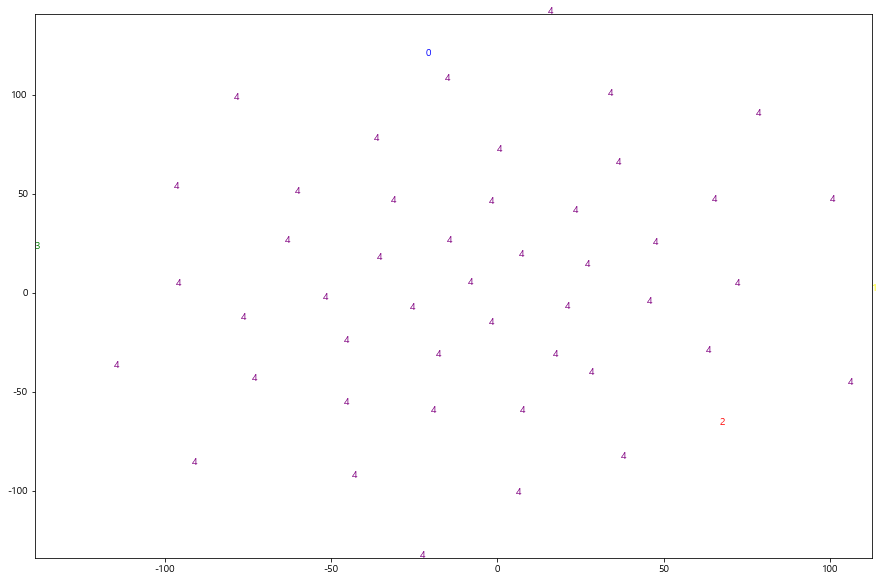

In [18]:
colors = {0:'blue', 1:'yellow', 2:'red', 3:'green', 4:'purple'}
x1 = tsne_review[:,0]
x2 = tsne_review[:,1]
plt.scatter(x1, x2)

plt.figure(figsize=(15,10))
plt.xlim(min(x1), max(x1))
plt.ylim(min(x2), max(x2))
for i in range(len(x1)):
#    plt.text(X1_lsi[i], X2_lsi[i], sample_label[i],
#            color = colors[sample_label[i]])
    plt.text(x1[i], x2[i], kmeans.labels_[i],
            color = colors[kmeans.labels_[i]])

#for word, pos in df.iterrows():
#    ax.annotate(word, pos, fontsize=30)
plt.show()

#아래 결과를 보면 각 topic들이 고르게 분포하고 있어, 클러스터링이 별로 의미 없음을 알 수 있음

#### 최적의 결과를 찾기 위한 방법

+ 적절한 topic의 수는 perplexity 값을 이용해 찾음.
+ 낮을 수록 좋은 모형이나, 사람의 판단과 일치하지 않을 수 있음
+ alpha, beta는 앞서 설명한 바와 같이 beta=0.1로 고정하고 alpha를 50/토픽수 근처에서 찾아나감
+ 반복횟수는 5,000번 정도면 수렴


In [19]:
lda.perplexity(review_cv)

580.3500674204244

In [20]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 25, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=2.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 영화, 스토리, 연기, 저승, 감동, 악역, 조폭, 상영, 윤계상, 지금
Topic #1: 영화, 가족, 감동, 노래, 디즈니, 점수, 주연, 자신, 조연, 픽사
Topic #2: 영화, 감동, 동안, 진짜, 더욱, 최고, 음악, 마음, 폭력, 장르
Topic #3: 인간, 엄마, 진짜, 하정우, 사람, 어머니, 모습, 영화, 하나, 순간
Topic #4: 광주, 영화, 국민, 전두환, 우리, 절대, 민주화, 당시, 해도, 외국
Topic #5: 영화, 신파, 중간, 연기, 명작, 코코, 정말, 기술, 언제, 몰입
Topic #6: 영화, 생각, 극장, 스토리, 재미, 가지, 감동, 걱정, 출연, 대박
Topic #7: 영화, 연출, 대한민국, 흥행, 반전, 얘기, 형사, 역사, 슬픔, 죽음
Topic #8: 영화, 차태현, 한국, 세계, 제대로, 신파극, 위해, 인정, 발전, 효과
Topic #9: 다음, 영화, 범죄, 편이, 추천, 마블, 도시, 꿀잼, 마동석, 번역
Topic #10: 영화, 감동, 만화, 부분, 대해, 자극, 볼거리, 정말, 생각, 스릴
Topic #11: 영화, 연기, 아쉬움, 마동석, 윤계상, 긴장감, 완성, 스크린, 평점, 기대
Topic #12: 원작, 영화, 스토리, 지옥, 웹툰, 오히려, 아들, 개연, 대사, 전혀
Topic #13: 영화, 어벤져스, 마블, 시리즈, 정말, 토르, 기대, 윤계상, 재미, 캐릭터
Topic #14: 영화, 눈물, 시민, 진실, 중반, 민주주의, 역사, 연기력, 실화, 등장
Topic #15: 영화, 관객, 정말, 시대, 모두, 감동, 희생, 남자, 나라, 배우
Topic #16: 영화, 영상, 이제, 집중, 감성, 감독, 배우, 정말, 눈물, 겨울왕국
Topic #17: 영화, 설정, 상황, 기분, 친구, 생각, 사실, 그때, 부모님, 조금
Topic #18: 영화, 이후, 이상, 보지, 관람, 평점, 역대, 감사, 알바, 진짜
Topic #19: 송강호, 영화, 배우, 택시,

561.3642266652979

In [21]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 10, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 감동, 보고, 스토리, 작품, 노스, 주인공, 모든, 어벤져스, 이제, 가장
Topic #1: 연기, 배우, 최고, 가족, 모두, 보기, 소재, 연기력, 조연, 이상
Topic #2: 영화, 음악, 부분, 인생, 최악, 여운, 영상, 뮤지컬, 보지, 무엇
Topic #3: 사람, 진짜, 하나, 차태현, 대박, 하정우, 소리, 인간, 지옥, 엄마
Topic #4: 광주, 역사, 다시, 가슴, 우리, 송강호, 한번, 택시, 지금, 사실
Topic #5: 정말, 눈물, 시간, 기대, 중간, 처음, 별로, 몰입, 실망, 관람
Topic #6: 생각, 재미, 스토리, 내용, 원작, 정도, 신파, 이해, 웹툰, 조금
Topic #7: 마지막, 장면, 감독, 사랑, 역시, 연출, 기억, 아이, 이야기, 대한
Topic #8: 그냥, 평점, 한국, 공포영화, 수준, 관객, 공포, 느낌, 천만, 한국영
Topic #9: 마동석, 윤계상, 마블, 액션, 완전, 추천, 다음, 결말, 때문, 아주



414.96166407293487